In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

# custom dataset class
from dataset_loader import CustomDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class ConvVAE(nn.Module):
    def __init__(self, in_channels, out_channels, latent_size):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2), # output 74x74
            nn.ReLU(inplace=True)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2), # output 36x36
            nn.ReLU(inplace=True)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2), # output 17x17
            nn.ReLU(inplace=True)
        )
        
        
        
        # Fully connected layers for mean and logvar
        self.mean_1 = nn.Sequential(
            nn.Linear(64*17*17, latent_size),
            nn.ReLU(inplace=True),
            nn.Linear(latent_size, 64 * 17 * 17),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (64, 17, 17))  # Reshape to match the shape after encoder
        )
        self.logvar_1 = nn.Sequential(
            nn.Linear(64*17*17, latent_size),
            nn.ReLU(inplace=True),
            nn.Linear(latent_size, 64 * 17 * 17),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (64, 17, 17))  # Reshape to match the shape after encoder
        )
        

        # Decoder
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=2, output_padding=0), # output 38x38
            nn.ReLU(inplace=True)
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=2, output_padding=0), # output 80x80
            nn.ReLU(inplace=True)
        )
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=6, stride=2, output_padding=0), # output 164x164
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=6, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=6, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=5, stride=1),  # output 150x150
            nn.Sigmoid()
        )

    def encode(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        mean = self.mean_1(x3.reshape(x3.shape[0],-1))
        logvar = self.logvar_1(x3.reshape(x3.shape[0],-1))
        return mean, logvar, x2, x3

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, x2, x3):
        z = self.decoder1(torch.cat((z,x3), dim=1))
        z = self.decoder2(torch.cat((z,F.pad(x2, (1,1,1,1), "constant", 0)), dim=1))
        z = self.decoder3(z)
        return z

    def forward(self, x):
        mean, logvar, x2, x3 = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z, x2, x3)
        return x_recon, mean, logvar

    def forward2(self, x, y):
        mean, logvar, x2, x3 = self.encode(x)
        mean, logvar, y2, y3 = self.encode(y)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z, x2, x3)
        return x_recon, mean, logvar

# Define the loss function for Convolutional VAE
def conv_vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Set random seed for reproducibility
torch.manual_seed(42)


cuda


In [2]:

def train_vae(model, train_loader, optimizer, num_epochs=5):
    # Training loop
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95)
    for epoch in tqdm(range(epochs)):
        model.train()
        
        for batch_idx, data in enumerate(train_loader):
            inputs, masks = data
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = conv_vae(inputs)
            loss = conv_vae_loss(recon_batch, masks, mu, logvar)
            loss.backward()
            optimizer.step()
            
            if batch_idx % 100 == 0:
                print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(inputs), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(inputs)))
        # decrease the learning rate    
        scheduler.step()



In [3]:

# Set your dataset path and other parameters
input_folder = "landscape_images\gray"
output_folder = "landscape_images\color"
batch_size = 64
latent_size = 20
epochs = 50
learning_rate = 1e-3


# Transformations for output images (no grayscale conversion)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load your dataset with separate transforms for input and output
dataset = CustomDataset(input_folder, output_folder, transform=transform)

# Split it into train and test data
train_size = int(0.8 * len(dataset))  # Adjust the split ratio as needed
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create the dataloader using only the transform for input images
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Instantiate the Convolutional VAE model and optimizer
# conv_vae = ConvVAE(in_channels=1, out_channels=3,latent_size=latent_size).to(device)


conv_vae = ConvVAE(in_channels=1, out_channels=3,latent_size=latent_size).to(device)
conv_vae.load_state_dict(torch.load("generative_models/005_params/005_vae_weights_g2c (1).pth"))
optimizer = optim.Adam(conv_vae.parameters(), lr=learning_rate)


In [4]:
%time

train=0

if train:
    train_vae(conv_vae, train_loader, optimizer, epochs)



Wall time: 0 ns


In [5]:
# save the model weights
save_params= 0
if save_params:
    torch.save(conv_vae.state_dict(), "generative_models/005_params/005_vae_weights_g2c.pth")
    torch.save(conv_vae, "generative_models/005_params/005_vae_g2c.pth")

In [7]:
# Load the trained model
conv_vae = ConvVAE(in_channels=1, out_channels=3,latent_size=latent_size).to(device)
conv_vae.load_state_dict(torch.load("generative_models/005_params/005_vae_weights_g2c (1).pth"))
conv_vae.eval()  # Set model to evaluation mode

# Create a test data loader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a loss function (e.g., mean squared error for regression)
criterion = nn.MSELoss()

# Evaluate on the test set
test = 0
if test:
    test_loss = 0.0
    with torch.no_grad():
        for targets in test_loader:
            outputs = conv_vae(targets)
            loss = criterion(outputs[0], targets)
            test_loss += loss.item() * targets.size(0)

    test_loss /= len(test_loader.dataset)
    print("Test Loss:", test_loss)


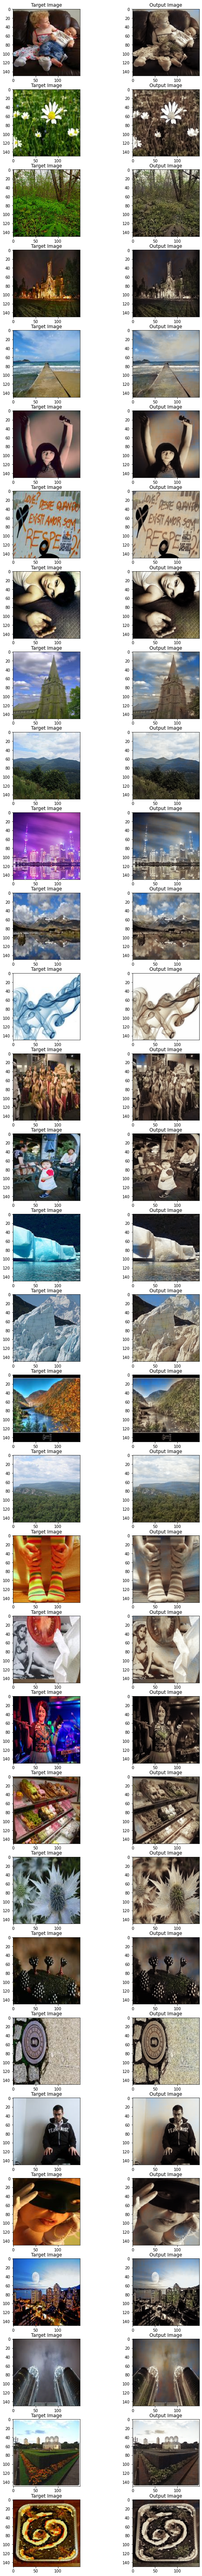

In [8]:

# Generate a sample from the Convolutional VAE, this part can be used for both image generation and noise testing
with torch.no_grad():
    sample = torch.randn([32, 3, 150, 150]).to(device)
    #sample = conv_vae.forward(sample)
    

# Get a test image and target
input_images, target_images = next(iter(test_loader)) # .to(device) #+sample*0.5
input_images, target_images = input_images.to(device), target_images.to(device)
output_images,_,_  = conv_vae(input_images)


# You can then visualize the generated samples using a library like matplotlib
fig, axes = plt.subplots(32, 2, figsize=(10,120))

for i in range(32):

    # Get the current target image
    output_image = output_images[i,:,:,:].squeeze().detach().cpu()

    # target_image is already a numpy array, just squeeze it:
    target_image = target_images[i,:,:,:].squeeze().detach().cpu()

    # Normalize predictions and targets to [0, 1]
    target_image = (target_image - target_image.min()) / (target_image.max() - target_image.min())
    output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())


    # torch tensor has permute
    axes[i,0].imshow(target_image.permute(1,2,0))
    axes[i,0].set_title("Target Image")
    # torch tensor has permute
    axes[i,1].imshow(output_image.permute(1,2,0))
    axes[i,1].set_title("Output Image")

plt.show()

In [ ]:
print(torch.Tensor(sample).shape)

In [ ]:
test_loss /= len(train_loader.dataset)
print("Test Loss:", test_loss)
